In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import pandas as pd
from affine import Affine
from functools import partial
from multiprocessing import Pool
from osgeo import gdal
import sys
sys.path.append('/home/ZhiLi/PlotGallary')
from matplotlibconfig import basic
basic()

In [16]:
siteDF= pd.read_excel('KCC_6AM_Lowvaluesites.xls')
# siteDF.set_index('stnm', inplace=True)

In [17]:
siteDF.head()

,OBJECTID,stnm,stid,name,city,rang,cdir,cnty,nlat,elon,...,N05,BULK5,GRAV5,SAND5,SILT5,CLAY5,TEXT5,datc,datd,RASTERVALU
0,1,11,BLAC,Blackwell,Blackwell,4,SSE,Kay,36.75443,-97.25452,...,1.33,1.43,0,28,49.2,23.0,Loam,19940101,20991231,0.673408
1,2,15,BRIS,Bristow,Bristow,4,SE,Creek,35.78050,-96.35404,...,1.34,1.27,0,64,11.9,23.9,Sandy clay loam,19940101,20991231,0.472602
2,3,17,BURB,Burbank,Burbank,7,SW,Osage,36.63459,-96.81046,...,1.56,1.34,0,20,53.9,26.0,Silt loam,19940101,20991231,0.646346
3,4,131,CARL,Lake Carl Blackwell,Orlando,5,E,Payne,36.14730,-97.28585,...,1.37,1.30,0,35,41.1,24.0,Loam,20080301,20991231,0.667642
4,5,24,CHAN,Chandler,Sparks,3,NNE,Lincoln,35.65282,-96.80407,...,1.37,1.50,0,76,15.7,8.8,Sandy loam,19940101,20991231,0.688824


In [25]:
def SMAP(df, fname):
    
    h5= h5py.File(fname, 'r')
    datetime= fname.split('/')[-1].split('_')[5]
#     smAct= h5['Soil_Moisture_Retrieval_Data_AM/soil_moisture'][:]
#     lonsAct= h5['Soil_Moisture_Retrieval_Data_AM/longitude'][:]
#     latsAct= h5['Soil_Moisture_Retrieval_Data_AM/latitude'][:]
    
    smPas= h5['Soil_Moisture_Retrieval_Data_PM/soil_moisture_pm'][:]
    lonsPas= h5['Soil_Moisture_Retrieval_Data_PM/longitude_pm'][:]
    latsPas= h5['Soil_Moisture_Retrieval_Data_PM/latitude_pm'][:]
    
    soilDF= pd.DataFrame()
    
    for i in range(len(df)):
        lon= df.elon.iloc[i]
        lat= df.nlat.iloc[i]
        
#         row, col= getIndex(lonsAct, latsAct, lon, lat)
        row, col= getIndex(lonsPas, latsPas, lon, lat)
        _soil= smPas[row, col]
#         if _soil<=-1:
#             row, col= getIndex(lonsPas, latsPas, lon, lat)
#             _soil= smPas[row, col]
            
        soilDF[df.stnm.iloc[i]]= _soil
        
    soilDF.index= [datetime]
    return soilDF
        
    

def getIndex(lons,lats, lon, lat):
    col= np.where(abs(lons[0,:] - lon)== np.nanmin(abs(lons[0,:] - lon)))[0]
    row= np.where(abs(lats[:,0] - lat) == np.nanmin(abs(lats[:, 0] - lat)))[0]
                  
    return row, col
    
def NOAH(df, fname):
    try:
        gribs= pygrib.open(fname)
        grib= gribs.message(4)
        lats, lons= grib.latlons()
        arr= grib.values
        soilDF= pd.DataFrame()
        gribs.close()
        datetime= fname.split('.')[1][1:]+fname.split('.')[2]

        for i in range(len(df)):
            lon= df.elon.iloc[i]
            lat= df.nlat.iloc[i]

            row, col= getIndex(lons, lats, lon, lat)

            _soil= arr[row, col]

            soilDF[df.stnm.iloc[i]]= _soil

        soilDF.index= [pd.to_datetime(datetime, format='%Y%m%d%H%M')]
        
        return soilDF
    
    except OSError:
        return fname


In [19]:
thread= partial(SMAP, siteDF)
filePath = '/media/scratch/ZhiLi/SMAP/'
fnames= glob(filePath+'*.h5')
def main(files):
    pool= Pool(30)
    with Pool(30) as pool:
        results= pool.map(thread, files)
    df= pd.DataFrame()
    for result in results:
        df= pd.concat([df, result])
        
    return df

if __name__=='__main__':
    df= main(fnames)

In [22]:
smap= df.copy()

In [118]:
noah= pd.read_csv('Noah_site.csv')

In [119]:
meso= pd.read_csv('zhendata.csv', skiprows=1)

In [87]:
def clean(df, type='smap'):
    
    if type=='smap':
        df.rename(columns= {'Unnamed: 0': 'time'}, inplace=True)
        df.time= pd.to_datetime(df.time, format='%Y%m%d')
        df.sort_values(by='time', inplace=True)
        df.set_index('time', inplace=True)
        
    elif type=='noah':
        df.rename(columns= {'Unnamed: 0': 'time'}, inplace=True)
        df.time= pd.to_datetime(df.time, format='%Y-%m-%d %H:%M:%S')
        df.sort_values(by='time', inplace=True)
        df.set_index('time', inplace=True)
        df.index= df.index.tz_localize('UTC').tz_convert('US/Central').tz_localize(None)
        
    elif type=='meso':
        df= df.drop(0, axis=0)
        df.rename(columns= {'stnm': 'time'}, inplace=True)
        df.time= pd.to_datetime(df.time)
        df.sort_values(by='time', inplace=True)
        df.set_index('time', inplace=True)
        df.index= df.index.tz_localize('UTC').tz_convert('US/Central').tz_localize(None)
    
    
    df[df<0]= np.nan
    
    return df

In [120]:
smap_PM= clean(pd.read_csv('SMAP_site_PM.csv'),'smap')
meso= clean(meso, 'meso')
noah= clean(noah, 'noah')
# meso= meso.loc[:, smap_PM.columns]
# noah= noah.loc[:, smap_PM.columns]
# smap_PM= smap_PM.loc[:, [str(stn) for stn in siteDF.stnm]]
smap_AM= clean(pd.read_csv('SMAP_site_AM.csv'),'smap')
# smap_AM= smap_AM.loc[:, [str(stn) for stn in siteDF.stnm]]

In [121]:
smap_AM[smap_AM<-10]= np.nan
smap_PM[smap_PM<-10]= np.nan
smap_AM= smap_AM.apply(np.nanmean, axis=1)
smap_PM= smap_PM.apply(np.nanmean, axis=1)

noah= noah.apply(np.nanmean, axis=1)
meso= meso.apply(np.nanmean, axis=1)

/home/ZhiLi/env/lib/python3.6/site-packages/pandas/core/apply.py:285: RuntimeWarning: Mean of empty slice
  values, self.f, axis=self.axis, dummy=dummy, labels=labels


In [122]:
PM= pd.date_range(start='2015-04-01 18:00:00', end="2019-07-02 18:00:00", freq='D')
AM= pd.date_range(start='2015-04-01 6:00:00', end="2019-07-02 6:00:00", freq='D')

noah_AM= pd.DataFrame(index=AM, columns=['value'])
for time in AM:
    try:
        noah_AM.loc[time]= noah.loc[time]
    except:
        pass

In [123]:
noah_PM= noah.loc[PM]
meso_PM= meso.loc[PM]

Text(0.5, 1.0, '6PM')

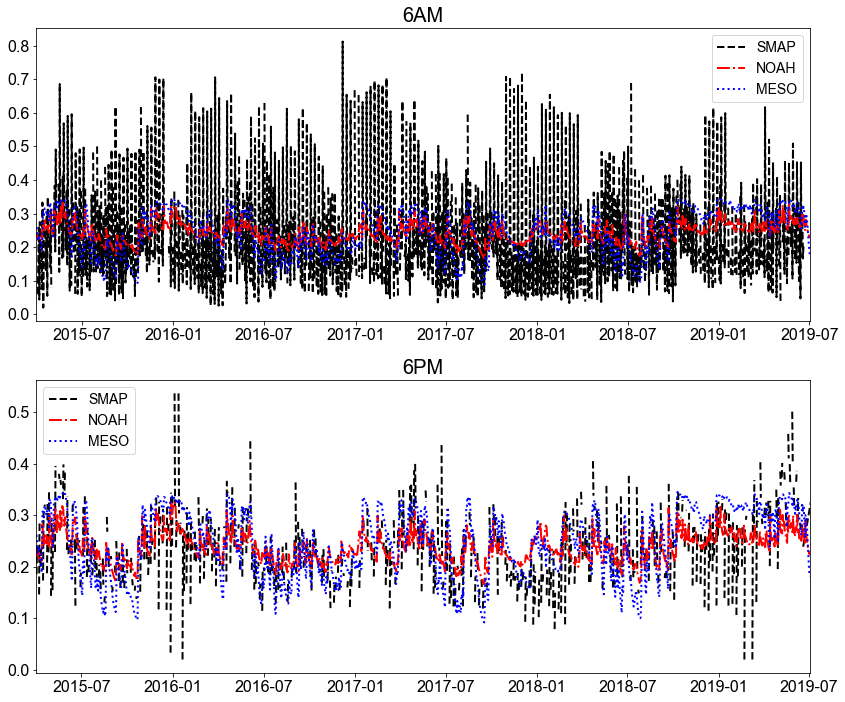

In [124]:
fig= plt.figure(figsize=(12,10))
ax= fig.add_subplot(211)
ax.plot(smap_AM.index, smap_AM.values, label='SMAP', color='black', linestyle='dashed')
ax.plot(noah_AM.index, noah_AM.values/100., label='NOAH', color='red', linestyle='dashdot')
ax.plot(AM, meso.loc[AM].values, label='MESO', color='blue', linestyle= ':')
ax.set_xlim([AM[0], AM[-1]])
ax.set_title('6AM')
ax.legend()
ax= fig.add_subplot(212)
ax.plot(smap_PM.index, smap_PM.values, label='SMAP', color='black', linestyle='dashed')
ax.plot(noah_PM.index, noah_PM.values/100., label='NOAH', color='red', linestyle='dashdot')
ax.plot(PM, meso.loc[PM].values, label='MESO', color='blue', linestyle= ':')
ax.set_xlim([PM[0], PM[-1]])
ax.legend()
ax.set_title('6PM')

In [2]:
cc= np.load('CC_raster.npy')

In [9]:
np.nanmean(cc[2])

0.7604856864824304